### Imports

In [1]:
import os, sys
import copy
from datetime import datetime

import seaborn as sns

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import RandomOverSampler

import sklearn
from sklearn.model_selection import train_test_split, cross_validate

import plotly
plotly.io.renderers.default = 'png'

# add my own file with custom utility functions as a module
utils_path = os.path.normpath(os.path.abspath(os.path.join(os.path.dirname('__file__'), os.path.pardir)))
if utils_path not in sys.path:
    sys.path.append(utils_path)

import aku_utils as ak

import pandas as pd
import numpy as np

import shap

# pandas options
pd.options.display.max_columns = 100
pd.options.display.max_rows =  200
# pd.options.display.max_info_rows = 1690785
pd.options.display.max_info_columns = 200
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.date_dayfirst = True
pd.options.mode.chained_assignment = None

### Data overview

In [2]:
df = pd.read_csv(os.path.join(os.path.dirname('__file__'), os.path.pardir, 'data', 'telco_processed_2.csv'))
df.head(-5)

,gender,age,married,number_of_dependents,latitude,longitude,number_of_referrals,phone_service,multiple_lines,avg_monthly_gb_download,online_security,online_backup,device_protection_plan,premium_tech_support,streaming_tv,unlimited_data,paperless_billing,total_refunds,total_extra_data_charges,total_long_distance_charges,satisfaction_score,churn,cltv,corr_total_charges,contract_one_year,contract_two_year,payment_method_credit_card,payment_method_mailed_check,offer_offer_b,offer_offer_c,offer_offer_d,offer_offer_e,offer_nan,internet_type_dsl,internet_type_fiber_optic,internet_type_nan,streaming_music_or_movies
0,1,78,0,0,34.02,-118.16,0,0,0,8,0,0,1,0,0,0,1,0.00,0.50,0.00,3,1,5433,19.82,0,0,0,0,0,0,0,0,1,1,0,0,1
1,0,74,1,1,34.04,-118.19,1,1,1,17,0,1,0,0,0,1,1,0.00,0.00,0.62,3,1,5302,126.66,0,0,1,0,0,0,0,1,0,0,1,0,0
2,1,71,0,3,34.11,-118.23,0,1,1,52,0,0,0,0,1,1,1,0.03,0.00,0.12,2,1,3179,438.14,0,0,0,0,0,0,1,0,0,0,1,0,1
3,0,78,1,1,33.94,-118.33,1,1,0,12,0,1,1,0,1,1,1,0.01,0.00,0.20,2,1,5337,502.90,0,0,0,0,0,1,0,0,0,0,1,0,1
4,0,80,1,1,33.97,-118.02,1,1,1,14,0,0,0,0,0,1,1,0.00,0.00,0.08,2,1,2793,717.04,0,0,0,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7033,0,23,1,0,33.28,-115.96,2,1,0,53,0,1,0,1,1,1,0,0.00,0.00,0.14,5,0,5553,865.25,0,1,0,0,0,0,0,0,1,1,0,0,0
7034,0,57,0,0,33.14,-116.97,0,1,0,0,0,0,0,0,0,0,1,0.00,0.00,0.35,3,0,5191,39.25,0,0,0,1,0,0,0,1,0,0,0,1,0
7035,1,63,0,0,33.04,-115.61,0,1,0,2,0,0,0,0,0,1,1,0.01,0.00,0.51,3,0,4591,875.08,0,0,1,0,0,0,0,0,1,0,1,0,0
7036,1,57,0,0,32.85,-114.85,0,1,0,13,0,0,0,0,1,1,1,0.02,0.00,0.38,3,0,2464,498.37,0,0,0,0,0,0,0,0,1,0,1,0,0


# Cross Validation

Since the dataset is rather small I believe the most appropriate models would be the ones based on decision trees. So, I will evaluate random forest, xgboost and catboost and choose the best as our model for churn prediction.

One of the most important characteristics of a model's quality is its ability to generalize patterns correctly so as it does not overfit on training data. So, I will choose the best model based on cross validation: each model will be trained and tested 5 times on different parts of the data. A model with the best generalization ability is the one that has the highest average test results.

In [3]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('churn', axis=1), df['churn'], test_size=0.20)

In [4]:
models = {'rf' : RandomForestClassifier(random_state=888),
          'xgboost' : XGBClassifier(seed=888),
          'catboost' : CatBoostClassifier(verbose=0, random_seed=888)}

cross_validate_result = []
for name, model in models.items():
    cv = cross_validate(model, X_train, y_train, cv=5, return_train_score=True, scoring='roc_auc')
    # cross_validate produces five folds of 
    cv = {key : value.sum() / len(value) for key, value in cv.items()}
    cv['name'] = name
    cross_validate_result.append(cv)

# display the results
cross_validate_result = pd.DataFrame.from_records(cross_validate_result)
with pd.option_context('display.float_format', None):
    display(cross_validate_result)

,fit_time,score_time,test_score,train_score,name
0,0.913645,0.027402,0.988745,1.00000,rf
1,0.345800,0.025200,0.991916,1.00000,xgboost
2,8.674806,0.032200,0.993921,0.99994,catboost


As we can see, the results of all models is pretty high, but catboost has the highest test result, which is something to be expected.

# Catboost

We have got to remember that our target is unbalanced, with churn rate being 26%. This imbalance would skew the results of the model, so we solve this problem by oversampling: we duplicate the observations of churned customers to achieve even distribution of classes.

This could, however, cause the model to overfit on noise in the minority class, so we have to be careful implementing this feature.

In [5]:
sampler = RandomOverSampler(sampling_strategy='minority')
X, y = sampler.fit_resample(df.drop('churn', axis=1), df['churn'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

model = CatBoostClassifier(random_seed=888)
model.fit(X_train, y_train)

Learning rate set to 0.025403
0:	learn: 0.6339228	total: 28.9ms	remaining: 28.9s
1:	learn: 0.5781834	total: 64.7ms	remaining: 32.3s
2:	learn: 0.5307035	total: 110ms	remaining: 36.6s
3:	learn: 0.4896875	total: 136ms	remaining: 33.9s
4:	learn: 0.4487235	total: 154ms	remaining: 30.7s
5:	learn: 0.4144328	total: 174ms	remaining: 28.8s
6:	learn: 0.3829807	total: 213ms	remaining: 30.3s
7:	learn: 0.3557768	total: 249ms	remaining: 30.8s
8:	learn: 0.3307002	total: 296ms	remaining: 32.6s
9:	learn: 0.3099232	total: 316ms	remaining: 31.3s
10:	learn: 0.2913841	total: 358ms	remaining: 32.2s
11:	learn: 0.2760728	total: 371ms	remaining: 30.6s
12:	learn: 0.2603108	total: 389ms	remaining: 29.5s
13:	learn: 0.2474651	total: 434ms	remaining: 30.5s
14:	learn: 0.2349443	total: 457ms	remaining: 30s
15:	learn: 0.2246093	total: 478ms	remaining: 29.4s
16:	learn: 0.2157555	total: 504ms	remaining: 29.1s
17:	learn: 0.2074297	total: 519ms	remaining: 28.3s
18:	learn: 0.2007089	total: 533ms	remaining: 27.5s
19:	learn: 

In [6]:
print(sklearn.metrics.classification_report(y_test, model.predict(X_test), digits=3))

              precision    recall  f1-score   support

           0      0.992     0.968     0.980      1044
           1      0.969     0.992     0.980      1026

    accuracy                          0.980      2070
   macro avg      0.980     0.980     0.980      2070
weighted avg      0.980     0.980     0.980      2070



We achieved 98% accuracy, which is very high.

In [7]:
print(f'Roc-auc score: {sklearn.metrics.roc_auc_score(y_test, model.predict_proba(X_test)[:,1]):.4f}')

Roc-auc score: 0.9987


The roc auc score turned out to be even higher than that for cross validation results. So, it is unlikely we overfit due to oversampling.

The [author](https://www.kaggle.com/code/alfathterry/telco-customer-churn-analysis#Modeling) of the dataset also evaluated the same model and achieved an accuracy and f1-score of 96%. So, our model turned out to be slightly more effective thanks to feature engineering and battling class imbalance problem.

# Evaluation on original data

Next, lets evaluate our model on original dataset to estimate its impact.

In [8]:
print(sklearn.metrics.classification_report(df['churn'], model.predict(df.drop('churn', axis=1)), digits=3))

              precision    recall  f1-score   support

           0      0.998     0.991     0.995      5174
           1      0.976     0.995     0.985      1869

    accuracy                          0.992      7043
   macro avg      0.987     0.993     0.990      7043
weighted avg      0.992     0.992     0.992      7043



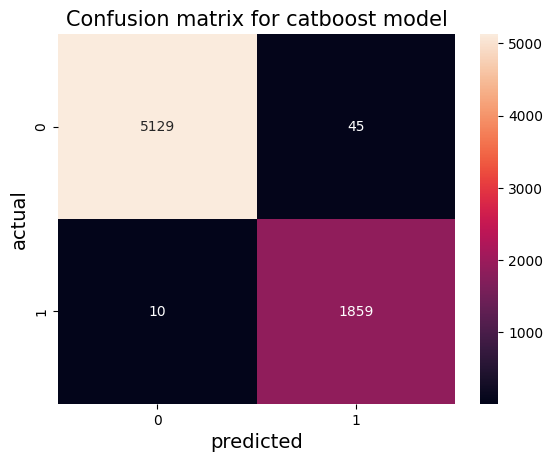

In [9]:
ax = sns.heatmap(sklearn.metrics.confusion_matrix(df['churn'], model.predict(df.drop('churn', axis=1))), annot=True, fmt='g')
ax.set_title('Confusion matrix for catboost model', fontsize=15)
ax.set_xlabel("predicted", fontsize=14)
ax.set_ylabel("actual", fontsize=14);

Our results on original data shows a 99% accuracy. A higher value than before is to be expected, since then we only estimated the model on test (unseen by the model) data.

Now lets compare this model to our other benchmark - IBM SPSS Modeler results:

In [10]:
ibm_spss_churn_prob = pd.read_csv(os.path.join(os.path.dirname('__file__'), os.path.pardir, 'data', 'telco_processed.csv'))['ibm_spss_churn_prob'] / 100
ibm_spss_churn_prob.describe()

count   7,043.00
mean        0.59
std         0.21
min         0.05
25%         0.40
50%         0.61
75%         0.76
max         0.96
Name: ibm_spss_churn_prob, dtype: float64

In [11]:
print(sklearn.metrics.classification_report(df['churn'], ibm_spss_churn_prob>0.5, digits=3))

              precision    recall  f1-score   support

           0      1.000     0.502     0.668      5174
           1      0.420     1.000     0.592      1869

    accuracy                          0.634      7043
   macro avg      0.710     0.751     0.630      7043
weighted avg      0.846     0.634     0.648      7043



Of course, our model is much more performant.

# Model explanation

Now, lets explore how different features affect the churn probability. We will use exclusively SHAP values for that.

In [12]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(df.drop('churn', axis=1))

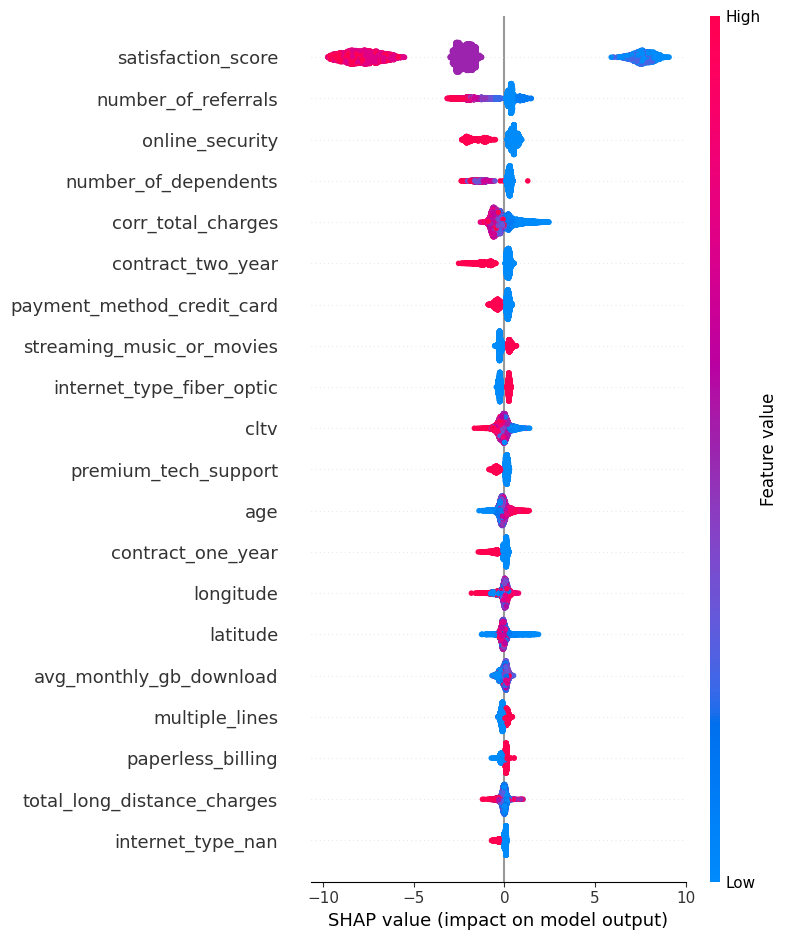

In [13]:
shap.summary_plot(shap_values=shap_values, max_display=20)

Interpretation: for every feature - for example, satisfaction score - SHAP draws a graph of how different values (scale is to the right) of this feature affect our target - in our case, churn. So, in case of the satisfaction score, we see that high values of satisfaction score - must be 4 or 5 - decrease chances for customers to churn significantly, medium values - must be 3 - only slightly decrease these chances, and, finally, low values - must be 1 or 2 - increase the chances for customers to leave drastically.

Insights:
* Satisfaction score is, expectedly, the most important feature for predicting customer churn. Scores as low as 1 or 2 are a strong indicator of customers leaving.
* Number of referrals are also indicators of churn
* People who use our online security service are less likely to leave, which suggests that this service is liked by customers
* Corrected total charges, which is the total charges divided by the number of services used, is one of the most impactful predictors of customer churn, which means that our feature engineering was successful.*
* Longer contracts decrease chances of customers churning, but that is just because they have less chances for churn.
* Customers with higher age have higher chances of churning, which could mean that they have less need for our services, or the services they do need - for example, phone service - is of lesser quality compared to competitors.
* Customers with dependants are less likely to leave, which, most likely, means that it is harder to change telecommunication service provider when you have kids.

P.S.: * - in absence of additional tests, you could argue that it is actually total_charges (not normalized charges) that influence the model, and our new feature does not actually have any impact. However, I compared this output with the output of the same model of the dataset [author](https://www.kaggle.com/code/alfathterry/telco-customer-churn-analysis#Modeling) and confirmed that total_charges by itself is not an impactful feature.

# Business simulation

Finally, we simulate how much customer lifetime value would business preserve using our model.

How does the implementation work like: we identify customers who are about to churn by using our model, send them personalized marketing offers, they respond positively and stay with the company, preserving their lifetime value.

Calculating the response rates are tricky and require us to go to outside sources. One [resource](https://instapage.com/blog/personalization-statistics/) says that 56% of people (across all generations) are willing to share their information if they receive personalized marketing offers. In other words, rate of engagement for personal offers is 56%. Now we need to evaluate how many people would go from responding to offer to accepting it. Unfortunately, I have not found numerical results for this ratio, but I believe that something in the range of 10 to 50% is adequate to assume.

Next, we evaluate how much lifetime value our model would preserve at different acceptance rates.

In [14]:
df['prediction'] = model.predict(df.drop('churn', axis=1))

In [15]:
personal_offer_to_response_rate = .56
respond_to_purchase_rates = [.1, .2, .3, .4, .5]

cltv_save = {}

for rate in respond_to_purchase_rates:
    # we assing to churned customers a chance to accept a personalized offer (accepted_offer column)
    df.loc[(df['churn'] == 1) & (df['prediction'] == 1), 'accepted_offer'] = np.random.choice([0, 1],
        size=((df['churn'] == 1) & (df['prediction'] == 1)).sum(), p=[1-personal_offer_to_response_rate*rate, personal_offer_to_response_rate*rate], seed=888)

    # we calculate how much customer lifetime value would be saved with given rates
    cltv_save[f'{rate:.0%}'] = df.loc[df['churn'] == 1, 'cltv'].sum() - df.loc[(df['churn'] == 1) & (df['accepted_offer'] == 0), 'cltv'].sum()

cltv_save

{'10%': 508728, '20%': 996050, '30%': 1300944, '40%': 1786098, '50%': 2092305}

In [16]:
cltv_save_df = pd.Series(cltv_save, name='cltv saved').to_frame().reset_index()
cltv_save_df.columns = ['response to<br>acceptance rate', 'cltv saved']
cltv_save_df

,response to<br>acceptance rate,cltv saved
0,10%,508728
1,20%,996050
2,30%,1300944
3,40%,1786098
4,50%,2092305


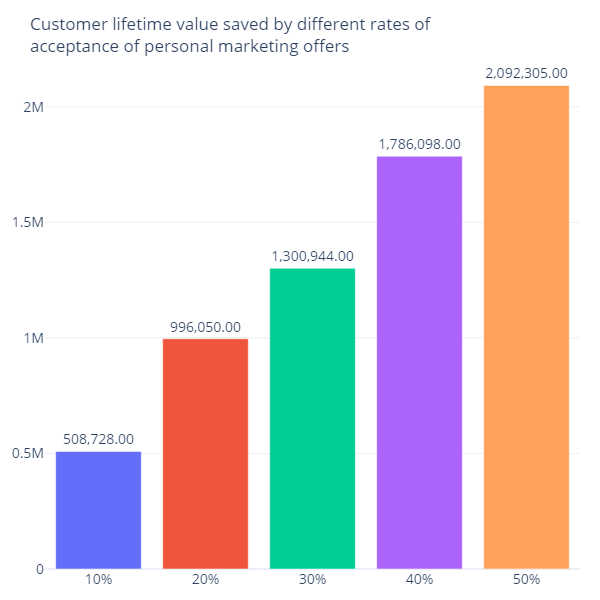

In [17]:
fig = ak.plot.bar(cltv_save_df, display_pct=False,
                  title='Customer lifetime value saved with model implementation')
fig.update_layout(width=600, height=600, xaxis_title='Offer response to acceptance', yaxis_title='Lifetime value saved')

Absolute values are not very telling, lets plot how much % of lifetime value would be saved instead.

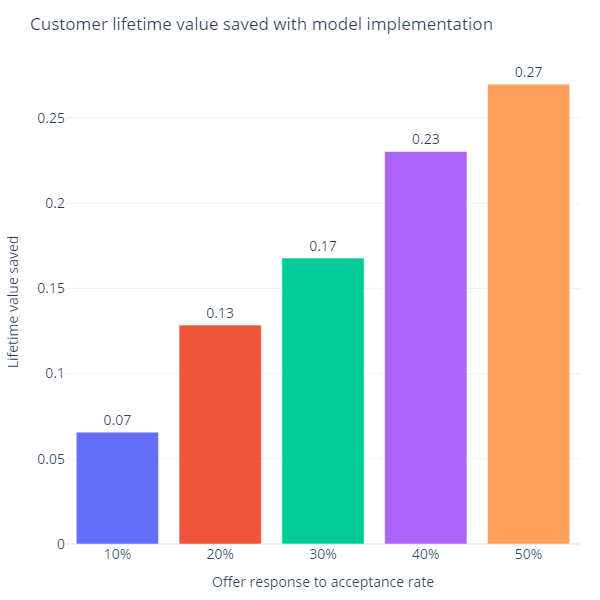

In [22]:
cltv_save_df = pd.Series({rate : saved / df.loc[df['churn'] == 1, 'cltv'].sum() for rate, saved in cltv_save.items()}).reset_index()
cltv_save_df.columns = ['response to<br>acceptance rate', 'cltv saved']

fig = ak.plot.bar(cltv_save_df, display_pct=False,
                  title='Customer lifetime value saved with model implementation')
fig.update_layout(width=600, height=600, xaxis_title='Offer response to acceptance rate', yaxis_title='Lifetime value saved')

We see that we can save up to 27% of customer lifetime value by implementing the model to predict customer churn. We see such results at 28% acceptance rate (56%*.5) of personalized marketing offers.

# Summary

We performed cross validation to get the best model and used oversampling to battle the class imbalance. We achieved very high results with Catboost model - 98% accuracy on test data - which outshined our benchmarks - a similar model made by the [author](https://www.kaggle.com/code/alfathterry/telco-customer-churn-analysis#Modeling) of the dataset and the results of a IBM SPSS model.

Insights about feature impact on churn:
* Satisfaction score is, expectedly, the most important feature for predicting customer churn. Scores as low as 1 or 2 are a strong indicator of customers leaving.
* Number of referrals is also an important factor for churn prediction.
* People who use our online security service are less likely to leave, which suggests that this service is liked by customers.
* Corrected total charges, which is the total charges divided by the number of services used, is one of the most impactful predictors of customer churn, which means that our feature engineering was successful.
* Customers with higher age have higher chances of churning, which could mean that they have less need for our services, or the services they do need - for example, phone service - is of lesser quality compared to competitors.
* Customers with dependants are less likely to leave, which, most likely, means that it is harder to change telecommunication service provider when you have kids.

Implementing our model for churn prediction could save from 7 to 27% of losses in customer lifetime value.